# Lung disease prediction from X-ray images
### Detection of covid and pneumonia
#### **Lorenzo Valentini**

## Data Preparation

In [1]:
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt 
import os
import glob
import tensorflow as tf
import keras
import seaborn as sn
import pandas as pd
%matplotlib inline

from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter as gaussian_filter

In [4]:
filepath = '/kaggle/input/lungs-30-08-3/'
splits = ["train-20230830T185553Z-001/train", "test-20230830T185545Z-001/test", "val-20230830T185555Z-001/val"]
labels = ["covid", "normal", "pneumonia"]
side = 224
for split in splits:
    filelist = []
    for label in labels:
        filelist =filelist + glob.glob(filepath + split+ "/" + label + '/*', recursive=True)
    if split == "train-20230830T185553Z-001/train":
        training_set = np.array([np.array(Image.open(fname).convert('L').resize((side, side)), dtype=np.int64) for fname in filelist], dtype=np.int64)
        trainpaths = filelist
    if split == "test-20230830T185545Z-001/test":
        test_set = np.array([np.array(Image.open(fname).convert('L').resize((side, side)), dtype=np.int64) for fname in filelist], dtype=np.int64)
        testpaths = filelist
    if split == "val-20230830T185555Z-001/val":
        valpaths = filelist
        validation_set = np.array([np.array(Image.open(fname).convert('L').resize((side, side)), dtype=np.int64) for fname in filelist], dtype=np.int64)
        
label_redirection = {0: "covid", 1: "normal", 2: "pneumonia"}
training_labels = 1244*[0] + 1236*[1]+ 1220*[2]
test_labels = 77*[0] + 77*[1]+ 77*[2]
validation_labels = 228*[0] + 228*[1]+ 228*[2]

In [ ]:
plt.figure(figsize = [12,12])
sample = 150

plt.subplot(121)
current_image = np.reshape(training_set[sample], (side, side))
current_label = training_labels[sample]
plt.imshow(current_image, cmap = "gray")
plt.title(str(label_redirection[current_label]))

plt.subplot(122)
current_image = np.reshape(test_set[sample], (side, side))
current_label = test_labels[sample]
plt.imshow(current_image, cmap = "gray")
plt.title(str(label_redirection[current_label]))
print(testpaths[sample])

/kaggle/input/lungs-30-08-3/test-20230830T185545Z-001/test/covid/COVID-19 (403).jpg


Text(0.5, 1.0, '(Label: covid)')

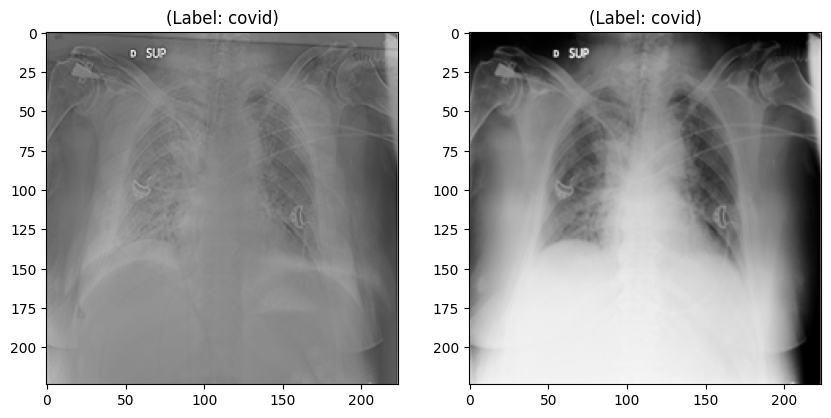

In [10]:
plt.figure(figsize=[12,12])

plt.subplot(122)
current_image = np.reshape(training_set[sample], (side, side))
current_label = training_labels[sample]
plt.imshow(current_image, cmap = "gray")
plt.title(str(label_redirection[current_label]))

training_set = (training_set - gaussian_filter(training_set, sigma = 0.4, mode = "nearest"))
validation_set = (validation_set - gaussian_filter(validation_set, sigma = 0.4, mode = "nearest"))

plt.subplot(121)
current_image = np.reshape(training_set[sample], (side, side))
current_label = training_labels[sample]
plt.imshow(current_image, cmap = "gray")
plt.title(str(label_redirection[current_label]))

## Models

In [11]:
batch_size = 32
epochs = 100
x, y = side, side
input_image = Input(shape = (x, y, 1))
num_classes = 3

In [12]:
def encoder(input_image):
    layer1 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(input_image) 
    layer1 = BatchNormalization()(layer1)
    layer1 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(layer1)
    layer1 = BatchNormalization()(layer1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(layer1) 
    layer2 = Conv2D(64, (3, 3), activation = "relu", padding = "same")(pool1) 
    layer2 = BatchNormalization()(layer2)
    layer2 = Conv2D(64, (3, 3), activation = "relu", padding = "same")(layer2)
    layer2 = BatchNormalization()(layer2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(layer2) 
    layer3 = Conv2D(128, (3, 3), activation = "relu", padding = "same")(pool2) 
    layer3 = BatchNormalization()(layer3)
    layer3 = Conv2D(128, (3, 3), activation = "relu", padding = "same")(layer3)
    layer3 = BatchNormalization()(layer3)
    layer4 = Conv2D(256, (3, 3), activation = "relu", padding = "same")(layer3) 
    layer4 = BatchNormalization()(layer4)
    layer4 = Conv2D(256, (3, 3), activation = "relu", padding = "same")(layer4)
    layer4 = BatchNormalization()(layer4)
    return layer4

def decoder(layer4):    
    layer5 = Conv2D(128, (3, 3), activation = "relu", padding = "same")(layer4) 
    layer5 = BatchNormalization()(layer5)
    layer5 = Conv2D(128, (3, 3), activation = "relu", padding = "same")(layer5)
    layer5 = BatchNormalization()(layer5)
    layer6 = Conv2D(64, (3, 3), activation = "relu", padding = "same")(layer5)
    layer6 = BatchNormalization()(layer6)
    layer6 = Conv2D(64, (3, 3), activation = "relu", padding = "same")(layer6)
    layer6 = BatchNormalization()(layer6)
    up1 = UpSampling2D((2,2))(layer6) 
    layer7 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(up1) 
    layer7 = BatchNormalization()(layer7)
    layer7 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(layer7)
    layer7 = BatchNormalization()(layer7)
    up2 = UpSampling2D((2,2))(layer7) 
    decoded = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(up2) 
    return decoded

def plotter(classify_training):
    accuracy = classify_training.history['accuracy']
    val_accuracy = classify_training.history['val_accuracy']
    loss = classify_training.history['loss']
    val_loss = classify_training.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def ffnn(encoded_image):
    flattened = Flatten()(encoded_image)
    den = Dense(128, activation = "relu")(flattened)
    output = Dense(3, activation = "softmax")(den)
    return output

def the_confusion_matrix(data_real, data_predicted):
    conf_matrx = [[0,0,0], [0,0,0], [0,0,0]]
    for i in list(range(0,len(data_real))):
        if (data_real[i] == 0) and (data_predicted[i] == 0):
            conf_matrx[0][0] = conf_matrx[0][0] + 1
        if (data_real[i] == 1) and (data_predicted[i] == 1):
            conf_matrx[1][1] = conf_matrx[1][1] + 1
        if (data_real[i] == 2) and (data_predicted[i] == 2):
            conf_matrx[2][2] = conf_matrx[2][2] + 1
        if (data_real[i] == 1) and (data_predicted[i] == 0):
            conf_matrx[0][1] = conf_matrx[0][1] + 1
        if (data_real[i] == 2) and (data_predicted[i] == 0):
            conf_matrx[0][2] = conf_matrx[0][2] + 1
        if (data_real[i] == 0) and (data_predicted[i] == 1):
            conf_matrx[1][0] = conf_matrx[1][0] + 1     
        if (data_real[i] == 2) and (data_predicted[i] == 1):
            conf_matrx[1][2] = conf_matrx[1][2] + 1  
        if (data_real[i] == 0) and (data_predicted[i] == 2):
            conf_matrx[2][0] = conf_matrx[2][0] + 1     
        if (data_real[i] == 1) and (data_predicted[i] == 2):
            conf_matrx[2][1] = conf_matrx[2][1] + 1  
    return conf_matrx

## Autoencoder Training

In [13]:
training_X, validation_X, training_ground, validation_ground = train_test_split(training_set, training_set, test_size = 0.2, random_state = 13)
autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder_train = autoencoder.fit(training_X, training_ground, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (validation_X, validation_ground))
autoencoder.save_weights('autoencoder_standard.h5')

Epoch 1/100
93/93 [==============================] - 63s 410ms/step - loss: 0.0485 - val_loss: 0.0011
Epoch 2/100
93/93 [==============================] - 30s 322ms/step - loss: 0.0064 - val_loss: 6.9982e-04
Epoch 3/100
93/93 [==============================] - 30s 320ms/step - loss: 0.0029 - val_loss: 4.9609e-04
Epoch 4/100
93/93 [==============================] - 30s 325ms/step - loss: 0.0012 - val_loss: 4.1667e-04
Epoch 5/100
93/93 [==============================] - 31s 330ms/step - loss: 0.0012 - val_loss: 3.6781e-04
Epoch 6/100
93/93 [==============================] - 31s 334ms/step - loss: 0.0019 - val_loss: 3.5957e-04
Epoch 7/100
93/93 [==============================] - 31s 336ms/step - loss: 5.8324e-04 - val_loss: 4.0482e-04
Epoch 8/100
93/93 [==============================] - 32s 341ms/step - loss: 4.0434e-04 - val_loss: 3.0680e-04
Epoch 9/100
93/93 [==============================] - 33s 350ms/step - loss: 4.1628e-04 - val_loss: 3.4593e-04
Epoch 10/100
93/93 [==================

In [14]:
autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.load_weights('autoencoder_standard.h5')

## Classifier Partial Training

In [17]:
training_Y_one_hot = to_categorical(training_labels)
test_Y_one_hot = to_categorical(test_labels)
validation_Y_one_hot = to_categorical(validation_labels)
encode = encoder(input_image)
classifier_model = Model(input_image, ffnn(encode))

for layer1, layer2 in zip(classifier_model.layers[:19], autoencoder.layers[0:19]):
    layer1.set_weights(layer2.get_weights())
for layer in classifier_model.layers[0:19]:
    layer.trainable = False
    
classifier_model.compile(loss = keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
classify_training = classifier_model.fit(training_set, training_Y_one_hot, batch_size = 32, epochs = 100, verbose = 1, validation_data = (validation_set, validation_Y_one_hot))
classifier_model.save_weights('final_autoencoder_classification.h5')

Epoch 1/100
116/116 [==============================] - 15s 115ms/step - loss: 39.0449 - accuracy: 0.7600 - val_loss: 18.9737 - val_accuracy: 0.7968
Epoch 2/100
116/116 [==============================] - 11s 96ms/step - loss: 8.3737 - accuracy: 0.8573 - val_loss: 13.6536 - val_accuracy: 0.8406
Epoch 3/100
116/116 [==============================] - 11s 96ms/step - loss: 5.0648 - accuracy: 0.8749 - val_loss: 20.0000 - val_accuracy: 0.8289
Epoch 4/100
116/116 [==============================] - 10s 85ms/step - loss: 5.7277 - accuracy: 0.8859 - val_loss: 14.8668 - val_accuracy: 0.8538
Epoch 5/100
116/116 [==============================] - 10s 85ms/step - loss: 1.5205 - accuracy: 0.9165 - val_loss: 13.6779 - val_accuracy: 0.8406
Epoch 6/100
116/116 [==============================] - 10s 85ms/step - loss: 0.9484 - accuracy: 0.9300 - val_loss: 15.8344 - val_accuracy: 0.8421
Epoch 7/100
116/116 [==============================] - 10s 85ms/step - loss: 2.6496 - accuracy: 0.9230 - val_loss: 14.9347

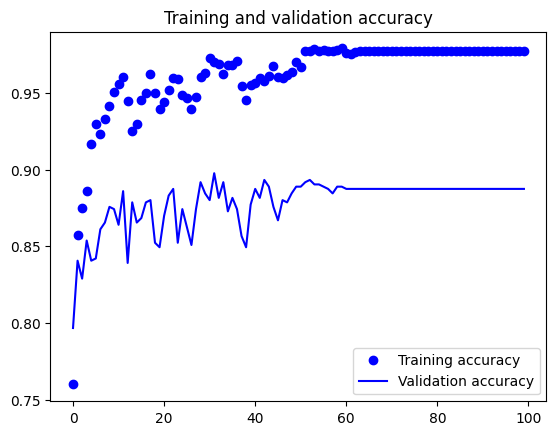

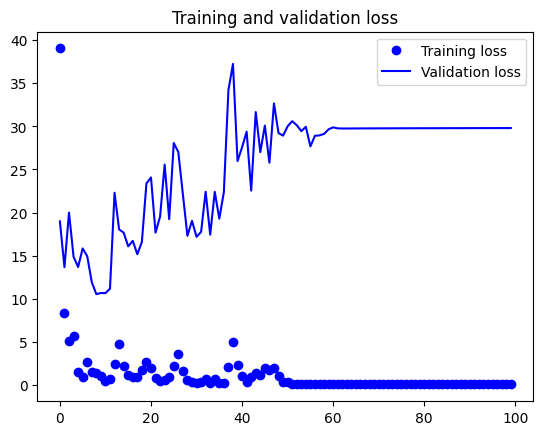

In [18]:
plotter(classify_training)

## Classifier Final Training

In [19]:
encode = encoder(input_image)
classifier_model = Model(input_image, ffnn(encode))
classifier_model.load_weights('final_autoencoder_classification.h5')

In [20]:
for layer in classifier_model.layers[0:19]:
    layer.trainable = True
classifier_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
full_classify_training = classifier_model.fit(training_set, training_Y_one_hot, batch_size = 32, epochs = 200, verbose = 1, validation_data = (validation_set, validation_Y_one_hot))
classifier_model.save_weights('final_full_classification.h5')

Epoch 1/200
116/116 [==============================] - 38s 266ms/step - loss: 9.3254 - accuracy: 0.7492 - val_loss: 22381.3418 - val_accuracy: 0.3436
Epoch 2/200
116/116 [==============================] - 28s 237ms/step - loss: 2.5751 - accuracy: 0.7100 - val_loss: 166.9004 - val_accuracy: 0.8523
Epoch 3/200
116/116 [==============================] - 29s 254ms/step - loss: 2.5860 - accuracy: 0.6911 - val_loss: 30.6392 - val_accuracy: 0.8348
Epoch 4/200
116/116 [==============================] - 28s 244ms/step - loss: 0.6347 - accuracy: 0.7792 - val_loss: 3.6804 - val_accuracy: 0.8377
Epoch 5/200
116/116 [==============================] - 28s 244ms/step - loss: 0.5646 - accuracy: 0.8111 - val_loss: 1.1351 - val_accuracy: 0.8333
Epoch 6/200
116/116 [==============================] - 30s 255ms/step - loss: 0.8165 - accuracy: 0.8097 - val_loss: 29.5344 - val_accuracy: 0.8216
Epoch 7/200
116/116 [==============================] - 28s 243ms/step - loss: 0.5562 - accuracy: 0.8297 - val_loss: 

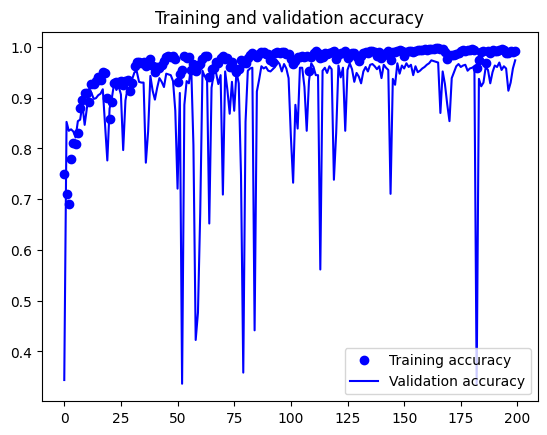

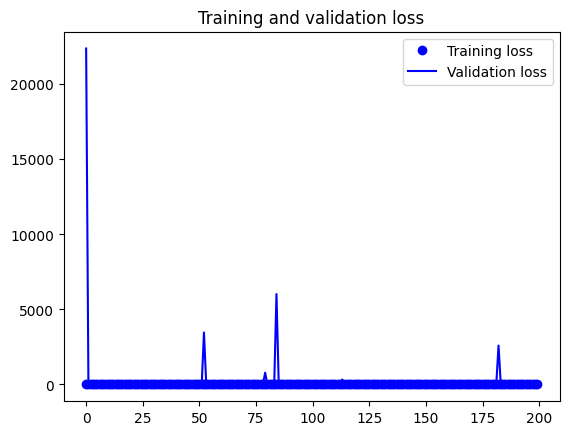

In [21]:
plotter(full_classify_train)

22/22 [==============================] - 1s 58ms/step


<Axes: >

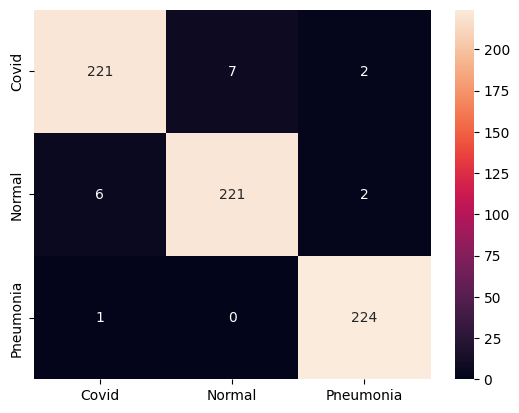

In [23]:
prediction_data = classifier_model.predict(validation_set)
prediction_class = np.argmax(prediction_data, axis = -1)
matrix = the_confusion_matrix(validation_labels, prediction_class)
confusionmatrix = pd.DataFrame(matrix, index = [i for i in ('Covid', 'Normal', 'Pneumonia')], columns = [i for i in ('Covid', 'Normal', 'Pneumonia')]) 
plt.figure()
sn.heatmap(confusionmatrix, annot = True,  fmt = 'g')